In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import numpy.linalg as la

matplotlib.use("module://matplotlib-backend-kitty")

np.set_printoptions(threshold=0)

%matplotlib inline

In [3]:
cities = np.genfromtxt("csv/Qatar.csv", delimiter=",")
cities = cities[1:, 1:]
n_cities = cities.shape[0]
cities

array([[24748.3333, 50840.    ],
       [24758.8889, 51211.9444],
       [24827.2222, 51394.7222],
       ...,
       [26133.3333, 51216.6667],
       [26133.3333, 51300.    ],
       [26150.2778, 51108.0556]])

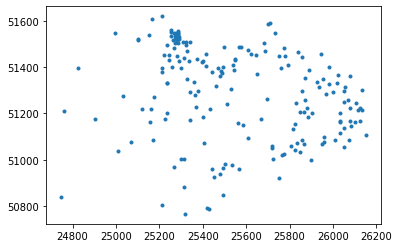

In [4]:
plt.scatter(cities[:, 0], cities[:, 1], marker=".")

In [5]:
def d(i, j):
    return np.linalg.norm(cities[i, :] - cities[j, :])

In [6]:
d(0, 1)

372.0941512342277

In [7]:
class Individual:
    def __init__(self, genome):
        self.genome = genome
        self.fitness = sum(
            [d(genome[i], genome[i + 1]) for i in range(0, len(genome) - 1)]
        ) + d(genome[len(genome) - 1], genome[0])

    # Muta al individuo
    def mutate(self):
        genome = np.copy(self.genome)
        i, j = np.random.choice(len(genome), size=2, replace=False)
        genome[i], genome[j] = genome[j], genome[i]
        return Individual(genome)

    # Two point crossover
    def cross(self, q):
        child = np.copy(self.genome)
        start, end = np.sort(np.random.choice(len(child), size=2, replace=False))
        child[:start] = child[end + 1 :] = -1
        child[child == -1] = np.setdiff1d(q.genome, child, assume_unique=True)
        return Individual(child)

    def __lt__(self, other):
        return self.fitness < other.fitness

    def __gt__(self, other):
        return self.fitness > other.fitness

    def __repr__(self):
        return "Individual(genome: {0}, fitness: {1})".format(
            self.genome.__str__(), self.fitness
        )

In [8]:
i = Individual(np.array([0, 5, 10, 15]))
i.fitness

1167.5008205274476

In [9]:
o = i.mutate()
o.genome, o.fitness, i.genome, i.fitness

(array([ 5,  0, 10, 15]),
 1166.451021692572,
 array([ 0,  5, 10, 15]),
 1167.5008205274476)

In [10]:
a = Individual(np.array([1, 2, 3, 4, 5]))
b = Individual(np.array([2, 1, 3, 5, 4]))
c = a.cross(b)
a.genome, b.genome, c.genome

(array([1, 2, 3, 4, 5]), array([2, 1, 3, 5, 4]), array([1, 2, 3, 5, 4]))

In [11]:
# DEPRECATED: Lo generaliza greedy_popuation con ratio=0
def random_population(n_population):
    # TODO: Generar individuos aleatorios
    return np.array(
        [Individual(np.random.permutation(n_cities)) for _ in range(n_population)]
    )

In [12]:
def greedy_popuation(n_population, ratio=1 / 2):
    """
    Genera población parte aleatoria parte generada mediante nearest neighbours

    Args:
        n_population: Tamaño total de la población
        ratio: Qué porcentaje de la población se genera greedily. 0 -> toda random
    """
    # Guardamos la población generada en population
    population = []

    # Primero generamos los de nearest neighbours
    n_greedy = round(n_population * ratio)
    n_random = n_population - n_greedy

    for _ in range(n_greedy):
        # Anotamos las ciudades visitadas modificando una copia de la lista de ciudades. Las
        # visitadas se vuelven nan. Asi se excluyen del cálculo de distancias.
        visitados = []
        index = range(len(cities))
        # Elegimos ciudad al azar
        curr_city = np.random.randint(0, len(cities))
        visitados.append(curr_city)
        city_record = np.copy(cities)

        while len(visitados) != len(index):
            city_record[curr_city] = np.nan

            distancias = la.norm(city_record - cities[curr_city], axis=1)
            # Tomamos la ciudad más cercana como actual
            curr_city = np.nanargmin(distancias)
            visitados.append(curr_city)

        # Añadiendo el individuo a la población
        population.append(Individual(visitados))

    # Generamos el resto de la población aleatoriamente
    population = population + [
        Individual(np.random.permutation(n_cities)) for _ in range(n_random)
    ]

    return np.array(population)

In [13]:
# El de menor fitness es el que tiene más probabilidades de reproducirse
def calculate_wheel_probability(population):
    fitnesses = np.array([p.fitness for p in population])
    # fitnesses = np.min(fitnesses) + np.max(fitnesses) - fitnesses
    # return fitnesses / np.sum(fitnesses)
    fitnesses = np.max(fitnesses) + 1 - fitnesses
    s = np.sum(fitnesses)
    return fitnesses / s

In [14]:
calculate_wheel_probability([i, o])

array([0.32789048, 0.67210952])

In [15]:
def GA(
    n_population=100,
    n_generation=1000,
    cross_rate=0.3,
    mutate_rate=0.2,
    greedy_rate=0,
    verbose=False,
    print_interval=10,
):
    """
    Resuelve el problema del agente viajero mediante una versión modificada de la estrategia del 
    algoritmos genéticos. Se genera una población del tamaño especificado y con las características 
    de aleatoriedad deseadas.

    Args:
        n_population: Tamaño total de la población
        n_generation: Número de generaciones
        cross_rate:
        mutate_rate:
        greedy_rate: Porcentaje de la población inicial que se genera mediante nearest neighbours
        verbose: Controla la cantidad de información que imprime el algoritmo
    """
    # Para la generación 0
    # Pk = random_population(n_population)
    Pk = greedy_popuation(n_population, greedy_rate)
    best_individual = Pk[Pk.argmin()]
    for k in range(1, n_generation):
        # Creamos la siguiente generacion
        Pk_next = np.array([])
        # Para seleccionar usamos wheel roulette selection
        # Calculamos la wheel probability
        wheel_prob = calculate_wheel_probability(Pk)

        # 1. Copy: seleccionamos (1 − cross_rate) × n individuos de Pk y los insertamos en Pk+1
        Pk_next = np.append(
            Pk_next,
            np.random.choice(
                Pk, round((1 - cross_rate) * n_population), p=wheel_prob, replace=False
            ),
        )

        # 2. Crossover: seleccionamos (cross_rate * n) parejas de Pk y los cruzamos para añadirlos en Pk+1
        parejas = np.random.choice(
            Pk, 2 * round(cross_rate * n_population), p=wheel_prob, replace=False
        ).reshape(-1, 2)
        Pk_next = np.append(Pk_next, [p.cross(q) for p, q in parejas])

        # 3. Mutate: seleccionamos mutate_rate de la población Pk+1 y la mutamos
        mutate_index = np.random.choice(
            len(Pk_next), int(mutate_rate * len(Pk_next)), replace=False
        )
        Pk_next[mutate_index] = np.array([x.mutate() for x in Pk_next[mutate_index]])

        # Acualizamos la generación
        Pk = Pk_next
        if Pk[Pk.argmin()] < best_individual:
            best_individual = Pk[Pk.argmin()]

        # Imprimimos status
        if verbose is True or k % print_interval == 0:
            print(f"Generation {k}: {best_individual}")
            # print(Pk)

    return best_individual

In [16]:
GA(n_population=20, n_generation=10, verbose=True)

Generation 1: Individual(genome: [111  65  34 ... 138 150 125], fitness: 87371.99531111222)
Generation 2: Individual(genome: [111  65  34 ... 138 150 125], fitness: 87371.99531111222)
Generation 3: Individual(genome: [111  65  34 ... 138 150 125], fitness: 87371.99531111222)
Generation 4: Individual(genome: [165  90 120 ... 105  59  53], fitness: 86849.45034567057)
Generation 5: Individual(genome: [165  90 120 ... 105  59  53], fitness: 86180.27270114262)
Generation 6: Individual(genome: [165  90 120 ... 105  59  53], fitness: 86180.27270114262)
Generation 7: Individual(genome: [165  90 120 ... 105  59  53], fitness: 86180.27270114262)
Generation 8: Individual(genome: [ 65  34 106 ... 190 138 150], fitness: 85881.15200650919)
Generation 9: Individual(genome: [ 65  34 106 ... 190 138 150], fitness: 85881.15200650919)


Individual(genome: [ 65  34 106 ... 190 138 150], fitness: 85881.15200650919)

In [17]:
GA(n_population=20, n_generation=10, greedy_rate=1 / 5, verbose=True)

Generation 1: Individual(genome: [50, 46, 38, 33, 39, 42, 40, 37, 45, 47, 51, 52, 53, 54, 48, 41, 43, 34, 31, 29, 30, 49, 55, 57, 60, 66, 65, 72, 67, 63, 69, 76, 78, 80, 82, 87, 91, 94, 95, 92, 96, 104, 105, 106, 107, 109, 111, 114, 115, 116, 120, 119, 127, 122, 123, 132, 134, 128, 130, 135, 147, 142, 154, 150, 146, 151, 152, 149, 143, 153, 156, 140, 138, 137, 141, 145, 148, 144, 139, 136, 133, 131, 126, 124, 125, 113, 112, 108, 101, 102, 90, 77, 74, 71, 73, 68, 59, 56, 44, 28, 21, 27, 32, 17, 20, 23, 25, 16, 13, 10, 12, 22, 24, 70, 75, 79, 86, 81, 61, 58, 35, 62, 64, 84, 85, 97, 89, 93, 98, 100, 103, 110, 88, 19, 15, 7, 5, 3, 1, 2, 4, 8, 9, 11, 14, 18, 26, 36, 83, 99, 117, 121, 118, 129, 155, 160, 162, 163, 168, 171, 178, 173, 172, 174, 183, 180, 176, 177, 179, 169, 166, 167, 164, 158, 157, 161, 165, 170, 184, 192, 187, 190, 188, 191, 189, 186, 185, 182, 181, 175, 193, 159, 6, 0], fitness: 12307.645134843728)
Generation 2: Individual(genome: [50, 46, 38, 33, 39, 42, 40, 37, 45, 47, 51

Individual(genome: [50, 46, 38, 33, 39, 42, 40, 37, 45, 47, 51, 52, 53, 54, 48, 41, 43, 34, 31, 29, 30, 49, 55, 57, 60, 66, 65, 72, 67, 63, 69, 76, 78, 80, 82, 87, 91, 94, 95, 92, 96, 104, 105, 106, 107, 109, 111, 114, 115, 116, 120, 119, 127, 122, 123, 132, 134, 128, 130, 135, 147, 142, 154, 150, 146, 151, 152, 149, 143, 153, 156, 140, 138, 137, 141, 145, 148, 144, 139, 136, 133, 131, 126, 124, 125, 113, 112, 108, 101, 102, 90, 77, 74, 71, 73, 68, 59, 56, 44, 28, 21, 27, 32, 17, 20, 23, 25, 16, 13, 10, 12, 22, 24, 70, 75, 79, 86, 81, 61, 58, 35, 62, 64, 84, 85, 97, 89, 93, 98, 100, 103, 110, 88, 19, 15, 7, 5, 3, 1, 2, 4, 8, 9, 11, 14, 18, 26, 36, 83, 99, 117, 121, 118, 129, 155, 160, 162, 163, 168, 171, 178, 173, 172, 174, 183, 180, 176, 177, 179, 169, 166, 167, 164, 158, 157, 161, 165, 170, 184, 192, 187, 190, 188, 191, 189, 186, 185, 182, 181, 175, 193, 159, 6, 0], fitness: 12307.645134843728)